In [1]:
import numpy as np
from threeflavorALLvalues import allSigmas
from scipy.integrate import odeint
from solveTmu import blackness
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.optimize import brentq, fsolve

from joblib import Parallel, delayed

import matplotlib.pyplot as plt


In [2]:
"Matching Fang paper"
v4=4.2
v3= -22.6/(6*np.sqrt(2))

def chiral(u,y,params):
    chi,chip=y
    v3,v4,lambda1,mu_g,a0,zh,q=params
    
    Q=q*zh**3
    
    
    "Ballon-Bayona version"
    phi = (mu_g*zh*u)**2-a0*(mu_g*zh*u)**3/(1+(mu_g*zh*u)**4)
    phip = 2*u*(zh*mu_g)**2+a0*(4*u**6*(zh*mu_g)**7/(1+(u*zh*mu_g)**4)**2-3*u**2*(zh*mu_g)**3/(1+(u*zh*mu_g)**4))

    f= 1 - (1+Q**2)*u**4 + Q**2*u**6
    fp= -4*(1+Q**2)*u**3 + 6*Q**2*u**5
    "EOM for chiral field"
    derivs=[chip,
            (3/u-fp/f+phip)*chip - (3*chi+lambda1*phi*chi-3*v3*chi**2-4*v4*chi**3)/(u**2*f)]
            #((3+u**4)/(u-u**5) +phip)*chip - (-3*chi+4*v4*chi**3)/(u**2-u**6) ]
            
    return derivs

def chiral_solve_IR(d0,lambda1,T,mu,ui,uf):
    numpoints=10000
    u=np.linspace(ui,uf,numpoints)
    u_backward=np.linspace(uf,ui,numpoints)


    zeta=np.sqrt(3)/(2*np.pi)

    mu_g=440
    a0=0

    lambda3=v3
    lambda4=v4


    zh,q = blackness(T,mu)
    Q=q*zh**3
    
    #defining constants for Taylor expansion at horizon u=1

    d1 = (3 * d0 - 3 * d0**2 * lambda3 - 4 * d0**3 * lambda4 + d0 * zh**2 * lambda1 * mu_g**2) / (2 * (-2 + Q**2))

    d2 = (1 / (16 * (-2 + Q**2)**2)) * (6 * d1 * (-6 + Q**2 + Q**4) +
    4 * d0**3 * (14 - 13 * Q**2) * lambda4 + d0**2 * ((42 - 39 * Q**2) * lambda3 - 24 * d1 * (-2 + Q**2) * lambda4) -
    2 * d1 * (-2 + Q**2) * zh**2 * (-8 + 4 * Q**2 - lambda1) * mu_g**2 +
    3 * d0 * (-14 + 13 * Q**2 + 8 * d1 * lambda3 - 4 * d1 * Q**2 * lambda3 + (-2 + 3 * Q**2) * zh**2 * lambda1 * mu_g**2))
    

    "IR boundary condition"
    chi0 = d0+d1*(1-uf)+d2*(1-uf)**2
    chip0 = -d1-2*d2*(1-uf)
    y0=[chi0,chip0]




    params=v3,v4,lambda1,mu_g,a0,zh,q
    
    "solve the EOM using solve_ivp"
    sol = solve_ivp(chiral, [uf, ui], y0, t_eval=u_backward, args=(params,))

    #sol=odeint(chiral,y0,u,args=(params,))
    #plot
    chi=sol.y[0][::-1]
    chip=sol.y[1][::-1]
 
    x=zeta*zh*ui
    #first-order approximation
    mq=chi[0]/(zeta*zh*ui)
    #second-order approximation
    mq1=(x-x*np.sqrt(1-12*v3*chi[0]))/(6*x**2*v3)


    return mq1,chi,chip,u

def sigma_finder(u_intermediate,chi,u,mq,T,mu,zeta,lambda3):
    zh,q = blackness(T,mu)

    "find sigma"
    chi_interp=interp1d(u,chi)
    sigma=(chi_interp(u_intermediate)-mq*zeta*zh*u_intermediate+3*mq**2*zeta**2*lambda3*(zh*u_intermediate)**2)/(u_intermediate*zh)**3*zeta
    return sigma


def chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1):
    results = Parallel(n_jobs=n_jobs)(
        delayed(chiral_solve_IR)(d0, lambda1, T, mu, ui, uf) for d0 in d0_array
    )
    # Unpack the results
    mq_array, chi_array, chip_array, u_array = zip(*results)
    
    return np.array(mq_array), np.array(chi_array), np.array(chip_array)

In [280]:
#run this to get the initial range of mq vs d0
#mq target should be 50 MeV or some large number
def initial_d0_mq(T,mu,mq_target,lambda1,ui,uf,d0_lower,d0_upper):
    
    d0_array=np.linspace(d0_lower,d0_upper,100)
    mq_array=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)[0]

    max_d0=d0_upper
    # find the indices where abs(mq_array)>150, and remove those indices from d0_array and mq_array
    indices=np.where(np.abs(mq_array)>150)
    # we don't need to go higher than the lowest d0 value that gives garbage results
    # if indices is not an empty array
    if len(indices[0])>0:
        max_d0=d0_array[indices[0]]
    if len(indices[0])>1:
        max_d0=max_d0[0]

    d0_array=np.delete(d0_array,indices)
    mq_array=np.delete(mq_array,indices)
#     mq1_array=np.delete(mq1_array,indices)
    
    iterations=0
    step_size=d0_array[1]-d0_array[0]
    while mq_array[-1]<mq_target and iterations<20:
    #while max(mq_array)<mq_target and iterations<12:

        #create a new d0_array starting above the maximum value of d0_array, with a spacing that is 1/10 of the spacing of the previous d0_array
        step_size=step_size/10
        d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)

        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),((d0_array[1]-d0_array[0])/100))
        # d0_new=np.arange(max(d0_array),min(max(d0_array)+(d0_array[-1]-d0_array[0])/10,max_d0),step_size)
        d0_array=np.concatenate((d0_array,d0_new))
        #calculate the mq_array for the new d0_array
        mq_new=chiral_solve_IR_parallel(d0_new, lambda1, T, mu, ui, uf, n_jobs=-1)[0]
        #add the new mq_array to the old mq_array
        mq_array=np.concatenate((mq_array,mq_new))
#         mq1_array=np.concatenate((mq1_array,mq1_new))

        
        indices=np.where(np.abs(mq_array)>1000)
        # we don't need to go higher than the lowest d0 value that gives garbage results
        # if indices is not an empty array
        if len(indices[0])>0:
            max_d0=d0_array[indices[0]]
        if len(indices[0])>1:
            max_d0=max_d0[0]    
        d0_array=np.delete(d0_array,indices)
        mq_array=np.delete(mq_array,indices)
#         mq1_array=np.delete(mq1_array,indices)

        # print(max_d0)
        old_max_d0=max_d0
        iterations=iterations+1
    # print('iterations',iterations)
    return d0_array,mq_array

# Initial solve from the IR
- Find an array of d0 values that will provide a good range of approximate quark masses.
    - Note that mq is solved to first-order here, so it will be corrected later
    - d0 array may be more densely filled in around the values that give the target quark mass
    - For low temperatures, we will get some negative quark masses
- For this array of d0 values, solve the differential equation again (from the IR), keeping the function $\chi(u)$ and its derivative


In [297]:
# finding a range of d0 values that will cover quark masses in a range from 0 to approximately mq_large
T=1
mu=0
mq_large=10
lambda1=5.6
ui=1e-4
uf=1-ui
d0_lower=0
d0_upper=100
d0_array, mq_array = initial_d0_mq(T, mu, mq_large, lambda1, ui, uf, d0_lower, d0_upper)

# solving from IR again to retain the function chi and its derivative chip for each value of d0
_,chis,chips=chiral_solve_IR_parallel(d0_array, lambda1, T, mu, ui, uf, n_jobs=-1)


/var/folders/p2/x0t9bzsx00jdh9552ryvxndm0000gp/T/ipykernel_85530/428286750.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(mq_array), np.array(chi_array), np.array(chip_array)


# Solving for $m_q$ and $\sigma$ simultaneously
Using the UV solution for the chiral field, we can algebraically solve for $m_q$ and $\sigma$ for a given $d_0$ value at a particular $u=u_{int}$. Here we keep terms up to $\mathcal{O}(z^3)$

In [298]:
#picking the value of u_int. There are 1000 points in u, so i ~ 1000*u_int
i=10
u=np.linspace(ui,uf,len(chips[0]))
u_int=u[i]
chi0=chis[:,i]
chip0=chips[:,i]
print(u_int)

0.001099899989999


In [299]:
#solving for mq and sigma
lambda3=v3
zeta=np.sqrt(3)/(2*np.pi)
zh,q=blackness(T,mu)
mq_improved=(1-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*lambda3*zeta*u_int*zh)
sigma_improved=zeta*(1-6*chi0*lambda3+3*chip0*u_int*lambda3-np.sqrt(1-3*lambda3*(3*chi0-chip0*u_int)))/(3*u_int**3*zh**3*lambda3)
# This is more accurate when mq is small, but there is no need to approximate
sigma_round=zeta*(chip0*u_int-chi0)/(2*u_int**3*zh**3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


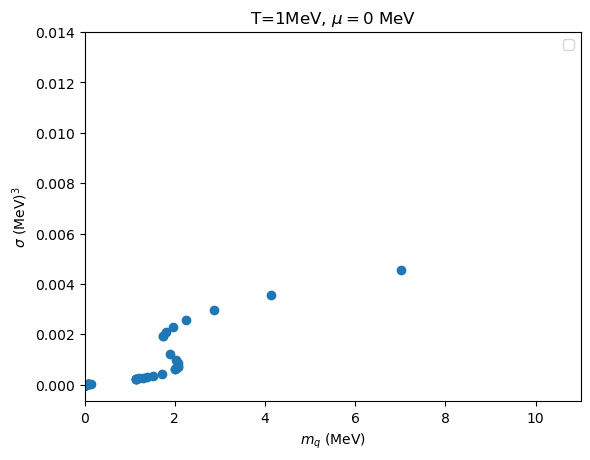

In [300]:
plt.scatter(mq_improved,sigma_improved/1e9)#,label="$u_{int}= $"+str(round(u[i]*1000)/1000))
# plt.plot(mq_array_1,sigma_1/1e9)
plt.xlabel("$m_q$ (MeV)")
plt.ylabel("$\sigma$ (MeV)$^3$")
plt.xlim(0,11)
plt.title("T="+str(T)+"MeV, $\mu=$"+str(mu)+" MeV")
plt.legend()
plt.show()

In [301]:
sigma_1=sigma_improved
mq_1=mq_improved

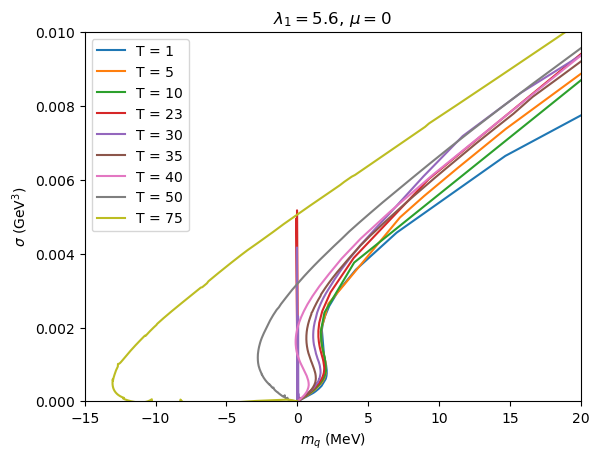

In [303]:
# plt.plot(mq_20,sigma_20/1e9,label="T = 20")
plt.plot(mq_1,sigma_1/1e9,label="T = 1")

plt.plot(mq_5,sigma_5/1e9,label="T = 5")

plt.plot(mq_10,sigma_10/1e9,label="T = 10")

plt.plot(mq_23,sigma_23/1e9,label="T = 23")
plt.plot(mq_30, sigma_30/1e9, label = "T = 30")
plt.plot(mq_35, sigma_35/1e9, label = "T = 35")

plt.plot(mq_40, sigma_40/1e9, label = "T = 40")

plt.plot(mq_50,sigma_50/1e9, label= "T = 50")
plt.plot(mq_75,sigma_75/1e9, label= "T = 75")

plt.title("$\lambda_1=5.6$, $\mu=0$")
plt.xlabel("$m_q$ (MeV)")
plt.ylabel("$\sigma$ (GeV$^3$)")
plt.xlim(-15,20)
plt.ylim(0,.01)
plt.legend()
plt.show()

In [293]:
np.max(d0_array)

54.14037211078792

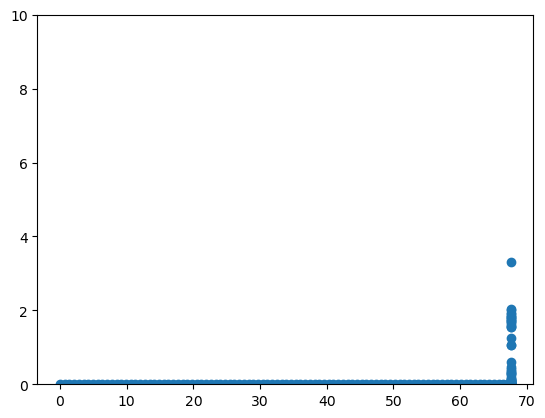

In [296]:
# plt.scatter(d0_array,mq_improved)
plt.scatter(d0_array,mq_array)
plt.ylim(0,10)
# plt.xlim(0,5)
plt.show()

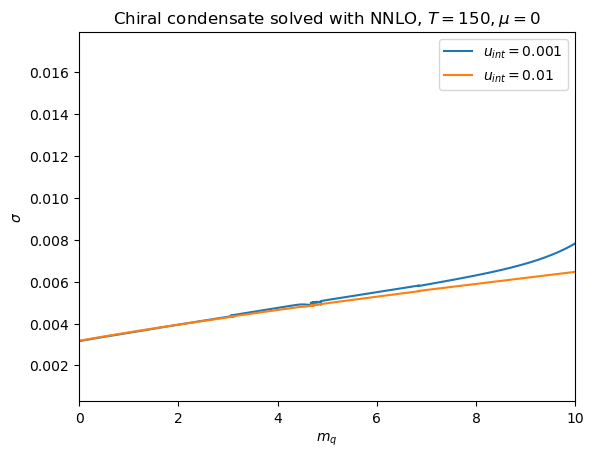

In [138]:
plt.plot(mq_array_1,(sigma_1/1e9),label="$u_{int}=0.001$")
plt.plot(mq_array_2,(sigma_2/1e9),label="$u_{int}=0.01$")

# plt.plot(mq_array_3,(sigma_3/1e9),label="$u_{int}=0.01$")
# plt.plot(mq_array_4,(sigma_4/1e9),label="$u_{int}=0.001$")
# plt.plot(mq_array_5,(sigma_5/1e9),label="$u_{int}=0.0007$")

plt.legend()
plt.xlim(0,10)
plt.xlabel("$m_q$")
plt.ylabel("$\sigma$")
# plt.plot(d0_array,sigma_improved)
plt.title("Chiral condensate solved with NNLO, $T=150, \mu=0$")
plt.show()

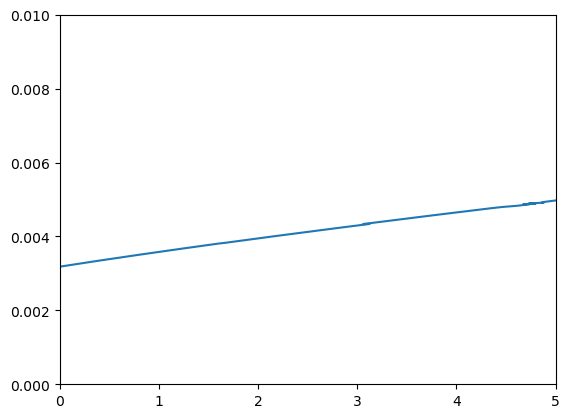

In [123]:
plt.plot(mq_improved,sigma_improved/1e9)
plt.xlim(0,5)
plt.ylim(0,.01)
plt.show()

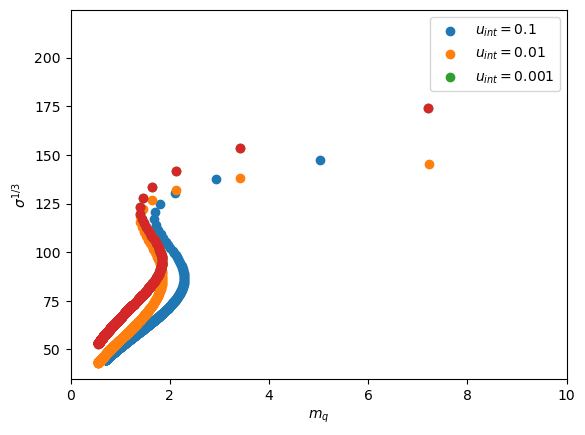

In [206]:
plt.scatter(mq_array_1,(sigma_1**(1/3)),label="$u_{int}=0.1$")
# plt.scatter(mq_array_2,(sigma_2**(1/3)),label="$u_{int}=0.2$")
plt.scatter(mq_array_3,(sigma_2**(1/3)),label="$u_{int}=0.01$")
plt.scatter(mq_array_4,(sigma_4**(1/3)),label="$u_{int}=0.001$")
plt.scatter(mq_array,sigma_4**(1/3))
plt.legend()
plt.xlim(0,10)
plt.xlabel("$m_q$")
plt.ylabel("$\sigma^{1/3}$")
# plt.plot(d0_array,sigma_improved)
plt.show()

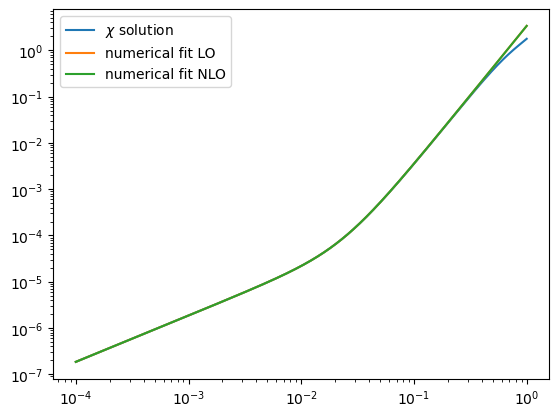

In [128]:
k=500
mq=mq_improved[k]
z=u*zh
lambda4=v4
mu_g=440
plt.loglog(u,chis[k],label="$\chi$ solution")
# plt.loglog(u,mq_improved[k]*zeta*zh*u+(70)**3/zeta*u**3*zh**3,label="Hand fit")
plt.loglog(u,mq_improved[k]*zeta*zh*u+sigma_improved[k]/zeta*u**3*zh**3,label="numerical fit LO")
plt.loglog(u,mq_improved[k]*zeta*zh*u+sigma_improved[k]/zeta*u**3*zh**3-3*(mq*zeta*z)**2*lambda3,label="numerical fit NLO")
# plt.xlim((1e-4,1e-3))
# plt.ylim((1e-7,1e-5))
plt.legend()
plt.show()

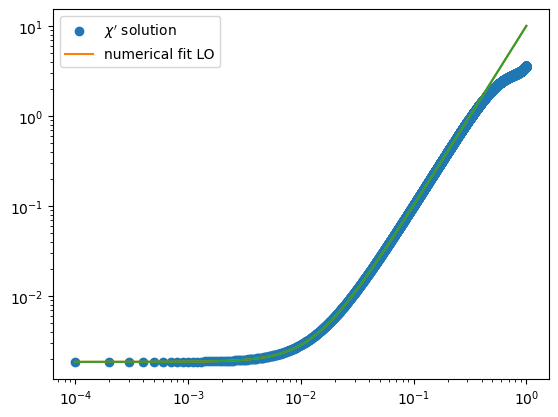

In [125]:
k=500
mq=mq_improved[k]
z=u*zh
lambda4=v4
mu_g=440
plt.loglog(u,chips[k],'o',label="$\chi'$ solution")
# plt.loglog(u,mq_improved[k]*zeta*zh+3*(90)**3/zeta*u**2*zh**3,label="Hand fit")
plt.loglog(u,mq_improved[k]*zeta*zh+3*sigma_improved[k]/zeta*u**2*zh**3,label="numerical fit LO")
plt.loglog(u,mq_improved[k]*zeta*zh+3*sigma_improved[k]/zeta*u**2*zh**3-6*u*(mq*zeta*zh)**2*lambda3)
# plt.xlim((1e-4,1e-3))
# plt.ylim((.007,.008))
plt.legend()
plt.show()

## Numerical solution (not needed)
Define the equations to solve for $m_q$ and $\sigma$ numerically. Needed (as a practical matter) if keeping terms of $\mathcal{O}(z^3\log z)$ or higher. (Technically can be solved exactly, but it's a cubic, so solutions are insanely long.)

### using `fsolve`
Doesn't give an improvement on initial guess (using the $\mathcal{O}(z^3)$ solutions), or it diverges.

In [331]:
def relations(vars,params):
    zh,zeta,ui,lambda3,lambda4,mu_g,chi0,chip0=params
    mq,sigma=vars
    x=zh*zeta*ui
    func=mq*x-3*mq**2*lambda3*x**2+sigma/zeta*(zh*ui)**3+(1/4) * (
    mq**3 * zeta**3 * (lambda4 - 36 * lambda3**2) + 2 * mq * zeta * mu_g**2 * (lambda1 - 2)
    ) * (zh*ui)**3 * np.log(zh*ui) -chi0
    deriv=mq*(zh*zeta)-6*mq**2*lambda3*(zh*zeta)**2+3*sigma/zeta*zh**3*ui**2+(1/4) * (
    mq**3 * zeta**3 * (lambda4 - 36 * lambda3**2) + 2 * mq * zeta * mu_g**2 * (lambda1 - 2)
    ) * (zh**3*ui**2+3*ui**2*zh**3*np.log(zh*ui))-chip0
    return func,deriv

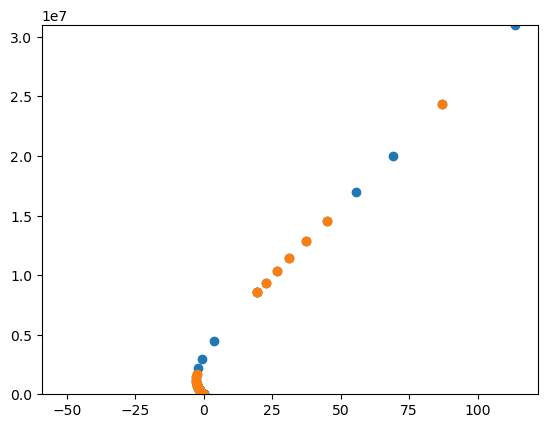

In [375]:
from scipy.optimize import fsolve

mu_g=440
zh,q=blackness(T,mu)
mq_numerical=np.zeros(len(mq_improved))
sigma_numerical=np.zeros(len(mq_improved))

for j in range(len(mq_improved)):
    inputs=zh,zeta,u[0],lambda3,v4,mu_g,chi0[j],chip0[j]
    mq_numerical[j],sigma_numerical[j]=fsolve(relations,args=(inputs,),x0=[mq_improved[j],sigma_improved[j]])

plt.scatter(mq_improved,sigma_improved)
plt.scatter(mq_numerical,sigma_numerical)
plt.ylim(0,max(sigma_improved))
plt.show()